In [1]:
from __future__ import print_function

import sys
import socket
import os

if socket.gethostname() == "qiaubuntu" or socket.gethostname() == "toologic-ubuntu2":
    repo_path = os.path.expanduser('~/repository/seg_uncertainty')
else:
    repo_path = os.path.expanduser('~/repo/seg_uncertainty')
sys.path.extend([repo_path])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import cv2
import SimpleITK as sitk
import torch
from tqdm import tqdm

import dill
import glob
from collections import OrderedDict

from datasets.data_config import get_config

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Ready")

Ready


In [4]:
patient_id = "patient021"
slice_id = 0
src_data_path = "/home/jorg/expers/acdc/unet_mc_dice"
amap_fname = os.path.join(os.path.join(src_data_path, "umaps"), patient_id + "_ES_emap.nii.gz")
a_map = sitk.GetArrayFromImage(sitk.ReadImage(amap_fname))
print(np.min(a_map), np.max(a_map))

0.0 0.38498726


In [23]:
from datasets.ACDC.get_data import get_pred_labels, get_umaps, load_data
from datasets.data_config import get_config
from datasets.ACDC.data import acdc_validation_fold


dta_settings = get_config('ACDC')

mc_dropout = False
patient_id = "patient023"

src_data_path = '/home/jorg/expers/acdc/f3/unet_mc_dice/'
type_of_data = ["pred_labels", "umaps", "ref_labels"]
data_dict = load_data(src_data_path, "ES", type_of_data, mc_dropout=mc_dropout, 
                      dt_config_id="fixed_46_31",
                      meta_info=False, patient_id=patient_id)
# dt_maps = data_dict["dt_maps"]
# dt_labels = data_dict["dt_labels"]
ref_labels = data_dict["ref_labels"]
umaps = data_dict["umaps"]
pred_labels = data_dict["pred_labels"]
apex_base = data_dict['apex_base_slices']
print(umaps.keys())
print(np.min(umaps[patient_id]['umap']), np.max(umaps[patient_id]['umap']))

dict_keys(['patient023'])
0.0 0.8093823


In [72]:
from datasets.ACDC.data import acdc_validation_fold
fold = 0
root_dir = '/home/jorg/data/ACDC/all_cardiac_phases/'
patid = 37
resample_zaxis = True

val_set = acdc_validation_fold(fold, root_dir=root_dir, limited_load=False, resample=False, 
                               patid=patid, 
                               resample_zaxis=resample_zaxis)
data = val_set.__next__()
print(data['reference'].shape)

(35, 256, 216)


In [52]:
def get_seg_errors(pred_labels, ref_labels):
    seg_errors = np.zeros_like(pred_labels)
    for cls_idx in np.arange(0, 4):
        seg_errors[(pred_labels == cls_idx) != (ref_labels == cls_idx)] = 1
    
    return seg_errors

seg_errors = get_seg_errors(pred_labels[patient_id], ref_labels[patient_id])
print(np.sum(seg_errors))

6478


In [98]:

err_indices = (np.sum(seg_errors, axis=1) >= 1).astype(np.bool)

a_map_perc = np.percentile(a_map, (0, 100))
print(np.sum(a_map))
print(a_map_perc)

# a_map_err = np.zeros_like(a_map)
# a_map_err[err_indices] = a_map[err_indices] > 0
a_map_err = a_map[err_indices]
print(a_map_err.shape)
print(np.sum(a_map_err != 0))
print(np.sum(a_map_err))

percs = [np.percentile(a_map_err, p) for p in range(1, 101, 1)]
print(len(percs))
print(percs)


231.67442
[0.         0.38498726]
(3239,)
3065
74.61873
100
[0.0, 0.0, 0.0, 0.0, 0.0, 3.5527132552840273e-15, 7.1054265105680546e-15, 1.4352961568288202e-14, 3.552713339987322e-14, 7.460698047854694e-14, 1.256239421298586e-13, 2.5266896973123733e-13, 4.812505407202072e-13, 7.980814923855276e-13, 1.4779286735405735e-12, 3.033306505279e-12, 5.903117127059601e-12, 1.2067429763784641e-11, 2.5197334080351297e-11, 6.932338453280457e-11, 1.5732956659686438e-10, 4.5811768378811753e-10, 1.164576519663286e-09, 3.2665621851890592e-09, 7.942472457500571e-09, 2.1917720403052953e-08, 3.45164625059625e-08, 5.6211695067531786e-08, 8.641456105351608e-08, 1.3793175241971766e-07, 2.1928652984115614e-07, 3.840398471766095e-07, 5.614724352653864e-07, 7.636501027263876e-07, 1.0655903906808797e-06, 1.490819013270084e-06, 2.064162140413827e-06, 2.4802981988614217e-06, 3.260771381974336e-06, 3.988798744103406e-06, 5.31920541106956e-06, 7.1137936356535675e-06, 9.226031979778781e-06, 1.1419773327361329e-05, 1.47

## Load segmentation-only results

**Important**: Don't forget to set mc dropout parameter properly


In [17]:
from evaluate.test_results import load_results

model_name = "drn_mc_dice"
src_path = "~/expers/acdc/*/" + model_name
mc_dropout = True

res_seg_only, _, _ = load_results(src_path, mc_dropout=mc_dropout, num_fold=4, 
                            file_prefix="results", num_patients=25)

print("INFO - ", res_seg_only.keys())

INFO - /home/jorg/expers/acdc/f0/drn_mc_dice/results_f0_25_mc.npz
INFO - /home/jorg/expers/acdc/f1/drn_mc_dice/results_f1_25_mc.npz
INFO - /home/jorg/expers/acdc/f2/drn_mc_dice/results_f2_25_mc.npz
INFO - /home/jorg/expers/acdc/f3/drn_mc_dice/results_f3_25_mc.npz
 & DRN-SD &  &  & 0.963$\pm$0.02 & 0.935$\pm$0.03 & 0.886$\pm$0.03  & 0.921$\pm$0.06 & 0.857$\pm$0.09 & 0.899$\pm$0.03 \\ 
 & DRN-SD &  &  &  5.7$\pm$3.2 & 11.5$\pm$5.1 & 8.0$\pm$5.5 & 8.3$\pm$4.5 & 13.3$\pm$5.1 & 8.9$\pm$5.1 \\
INFO -  dict_keys(['mean_dice_es', 'mean_dice_ed', 'std_dice_es', 'std_dice_ed', 'mean_hd_es', 'mean_hd_ed', 'std_hd_es', 'std_hd_ed', 'dice_es', 'dice_ed', 'hd_es', 'hd_ed'])


## Load combined segmentation-detection results

**Important**: Don't forget to set mc dropout parameter properly!

In [19]:
from evaluate.test_results import load_results_sim_correction

src_path = "~/expers/acdc/" + model_name
result_type = "detection"   # 'det_base' or 'detection' default='detection'


_ = load_results_sim_correction(src_path, mc_dropout=mc_dropout, 
                                result_type=result_type, base_results=res_seg_only)

Load results from /home/jorg/expers/acdc/drn_mc_dice/results_fall_100_mc.npz
 &  &  & x & 0.965$\pm$0.01 & *0.942$\pm$0.02 & 0.890$\pm$0.03  & 0.935$\pm$0.04 & *0.897$\pm$0.05 & *0.908$\pm$0.03 \\ 
 &  &  & x &  5.1$\pm$2.8 & *10.2$\pm$4.4 & 7.1$\pm$5.2 & *6.5$\pm$4.3 & *11.6$\pm$4.9 & *7.7$\pm$4.8 \\


dict_keys(['patient021'])


In [5]:
patient_id = "patient025"
print(pred_labels[patient_id].shape)
mask = np.argmax(pred_labels[patient_id], axis=1)
print(np.unique(mask))

(9, 4, 256, 256)
[0 1 2 3]


{'A': 7, 'B': 0}
(256, 216) (256, 216)
0.0 0.0


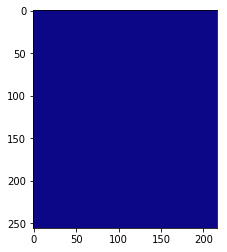

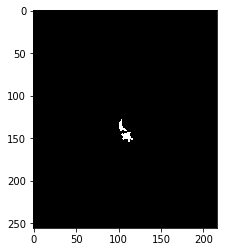

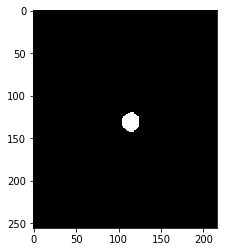

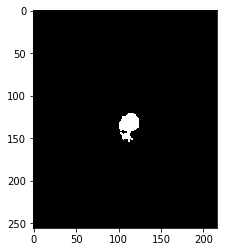

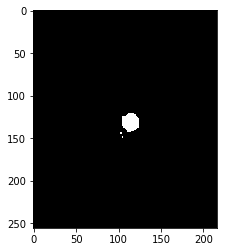

In [126]:
patient_id = "patient018"
max_slice = 7  #ref_labels[patient_id].shape[0] - 1
slice_id = max_slice


print(apex_base[patient_id])
dt_slice = np.sum(dt_labels[patient_id][slice_id], axis=0)
umap_slice = umaps[patient_id]['umap'][slice_id]
u_error = copy.deepcopy(umap_slice)
print(dt_slice.shape, u_error.shape)

u_error[u_error > 0.00001] = 0
print(np.min(u_error), np.max(u_error))

plt.imshow(u_error, cmap=plt.get_cmap('plasma'), vmin=0, vmax=0.00001)
plt.show()


plt.imshow(dt_slice, cmap=plt.get_cmap('gray'))
plt.show()

ref_slice = np.sum(ref_labels[patient_id][slice_id][1:], axis=0)
plt.imshow(ref_slice, cmap=plt.get_cmap('gray'))
plt.show()

pred_slice = np.sum(pred_labels[patient_id][slice_id][1:], axis=0)
plt.imshow(pred_slice, cmap=plt.get_cmap('gray'))
plt.show()


plt.imshow(pred_slice - dt_slice, cmap=plt.get_cmap('gray'))
plt.show()

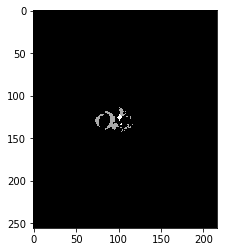

0.0075488887 0.6230238
0.0 0.6230238


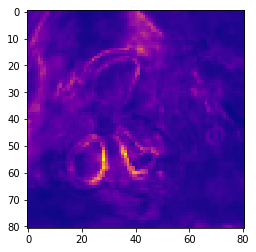

In [34]:
from utils.box_utils import find_box_four_rois, BoundingBox

patient_id = "patient037"
slice_id = 0
src_data_path = "/home/jorg/expers/acdc/f0/dcnn_mcc"
amap_fname = os.path.join(os.path.join(src_data_path, "umaps"), patient_id + "_ES_aleatoric.nii.gz")
a_map = sitk.GetArrayFromImage(sitk.ReadImage(amap_fname))
# normalize 
a_map = (a_map - np.min(a_map)) / (np.max(a_map) - np.min(a_map))
a_map_slice = a_map[slice_id]

fname = os.path.join(os.path.join(src_data_path, "pred_labels"), patient_id + "_ES.nii.gz")
pred_labels = sitk.GetArrayFromImage(sitk.ReadImage(fname))[slice_id]

slice_x, slice_y = BoundingBox.convert_to_slices(find_box_four_rois(pred_labels, padding=40)[0])

plt.imshow(pred_labels, cmap=plt.get_cmap('gray'))
plt.show()

# a_map_slice[slice_x, slice_y]
print(np.min(a_map_slice[slice_x, slice_y]), np.max(a_map_slice[slice_x, slice_y]))
print(np.min(a_map_slice), np.max(a_map_slice))
plt.imshow(a_map_slice[slice_x, slice_y], cmap=plt.get_cmap('plasma'))
plt.show()

(4, 256, 216) (4, 256, 216)
1.8167547e-07 0.11224558


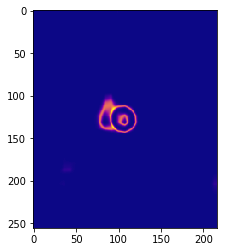

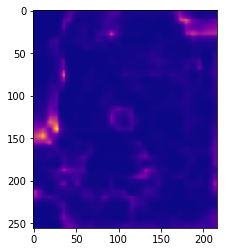

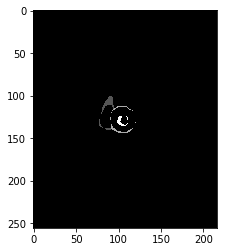

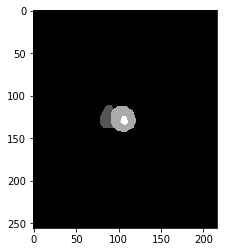

In [12]:
from utils.common import detect_seg_errors

patient_id = "patient037"
slice_id = 2


amap_fname = os.path.join(os.path.join(src_data_path, "umaps"), patient_id + "_ES_aleatoric.nii.gz")
a_map = sitk.GetArrayFromImage(sitk.ReadImage(amap_fname))[slice_id]
emap = umaps[patient_id]['umap'][slice_id]
pred_labels_slice = pred_labels[patient_id][slice_id]
ref_labels_slice = ref_labels[patient_id][slice_id]

print(pred_labels_slice.shape, ref_labels_slice.shape)
print(np.min(a_map), np.max(a_map))
seg_errors_slice = detect_seg_errors(ref_labels_slice, pred_labels_slice, is_multi_class=False)
pred_labels_multi = np.zeros_like(emap)
for i in np.arange(pred_labels_slice.shape[0]):
    pred_labels_multi[pred_labels_slice[i] == 1] = i

plt.imshow(emap, cmap=plt.get_cmap('plasma'))
plt.show()

plt.imshow(a_map, cmap=plt.get_cmap('plasma'))
plt.show()

plt.imshow(seg_errors_slice, cmap=cm.gray)
plt.show()

plt.imshow(pred_labels_multi.astype(np.int16), cmap=cm.gray)
plt.show()

In [57]:

fname = "~/expers/acdc/f0/dcnn_mc_brier/umaps/patient017_ES_bmap.nii.gz"
bmap = sitk.GetArrayFromImage(sitk.ReadImage(os.path.expanduser(fname)))
print(bmap.shape)
fname = "~/expers/acdc/f0/dcnn_mc_brier/umaps/patient017_ED_emap.nii.gz"
emap = sitk.GetArrayFromImage(sitk.ReadImage(os.path.expanduser(fname)))
print(emap.shape)

(9, 256, 216)
(9, 256, 216)


(7, 256, 216)


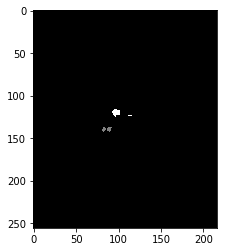

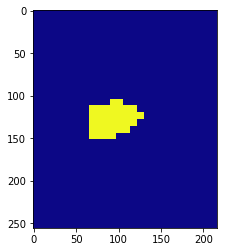

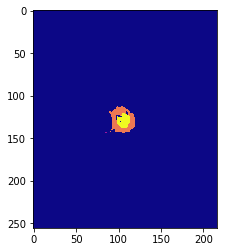

In [54]:
fname = "~/expers/acdc/dcnn_mc_dice/heat_maps/patient037_ED.nii.gz"
dt_probs_dice = sitk.GetArrayFromImage(sitk.ReadImage(os.path.expanduser(fname)))
fname = fname.replace("heat_maps", "corr_pred_labels")
dt_probs_brier = sitk.GetArrayFromImage(sitk.ReadImage(os.path.expanduser(fname)))
fname = fname.replace("corr_pred_labels", "dt_labels/fixed_46_31")
fname = fname.replace(".nii.gz", ".npz")
dt_labels = np.argmax(np.load(os.path.expanduser(fname))['dt_ref_labels'], axis=1)
print(dt_labels.shape)

slice_id = 0

plt.imshow(dt_labels[slice_id], cmap=cm.gray)
plt.show()
plt.imshow(dt_probs_dice[slice_id] >= 0.5, cmap=cm.plasma)
plt.show()
plt.imshow(dt_probs_brier[slice_id], cmap=cm.plasma)
plt.show()

(8, 256, 216) int32 [0 1 2 3]


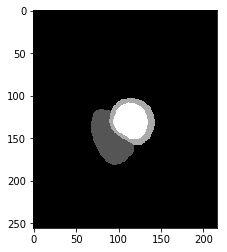

In [20]:
fname = os.path.expanduser("~/expers/acdc/drn_mc_ce/corr_pred_labels/patient018_ES.nii.gz")
corr_labels = sitk.GetArrayFromImage(sitk.ReadImage(fname))
print(corr_labels.shape, corr_labels.dtype, np.unique(corr_labels))

plt.imshow(corr_labels[0], cmap=cm.gray)
plt.show()

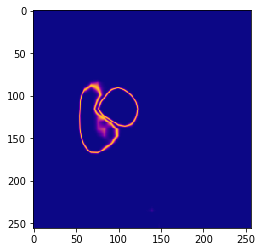

In [84]:
plt.imshow(emap[11], cmap=cm.plasma)
plt.show()


In [56]:
fname = "/home/jorg/expers/acdc/drn_mc_augbrierv2_cyclic/results_f0_25.npz"
results = np.load(fname)
print(results.files)
pat_ids, mean_dice_es, mean_hd_es = results['ids'], results['mean_dice_es'], results['mean_hd_es']
mean_dice_ed, mean_hd_ed = results['mean_dice_ed'], results['mean_hd_ed']
print(np.round(mean_dice_ed, decimals=2))
print(np.round(mean_dice_es, decimals=2))
print(np.round(mean_hd_ed, decimals=2))
print(np.round(mean_hd_es, decimals=2))

['dice_es', 'dice_ed', 'hd_es', 'hd_ed', 'mean_dice_es', 'mean_dice_ed', 'mean_hd_es', 'mean_hd_ed', 'std_dice_es', 'std_dice_ed', 'std_hd_es', 'std_hd_ed', 'ids']
[0.   0.93 0.86 0.95]
[0.   0.87 0.88 0.9 ]
[ 0.   10.32  7.04  5.19]
[ 0.   13.51  9.47  9.72]


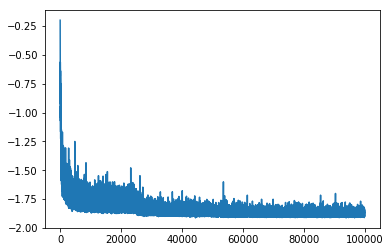

In [88]:
loss_fname = "/home/jorg/expers/acdc/drn_mc_dicev3/losses.npz"
loss = np.load(loss_fname)['training']

n=1
plt.plot(loss[:])
plt.show()

In [36]:
from datasets.ARVC.dataset import load_data

data_config = get_config(dataset="ARVC")
dataset = load_data(data_config, limited_load=True, load_ref_labels=True)

Load ARVC: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


In [39]:
print(dataset.keys())
patient_id = '30023_1'
frame_es = 9
frame_ed = 29
spacing = dataset[patient_id]['spacing'][1:]
labels_es = dataset[patient_id]['labels'][frame_es]
labels_ed = dataset[patient_id]['labels'][frame_ed]
lv_labels_es, rv_labels_es = labels_es == 1, labels_es == 2
lv_labels_ed, rv_labels_ed = labels_ed == 1, labels_ed == 2
print(lv_labels_es.shape, spacing)

dict_keys(['30010_0', '30022_0', '30023_0', '30023_1'])
(17, 256, 256) [8.00000095 1.20814538 1.20814538]


In [44]:
from utils.cardiac_indices import compute_ejection_fraction

esv, edv, ef = compute_ejection_fraction(lv_labels_es, lv_labels_ed, spacing)
print(esv, edv, ef, edv-esv)

102.34823418045137 200.27091436724717 48.89510815695878 97.9226801867958


(8, 256, 256) (8, 256, 256)
[0. 1.]


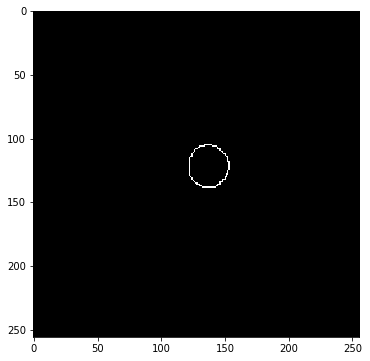

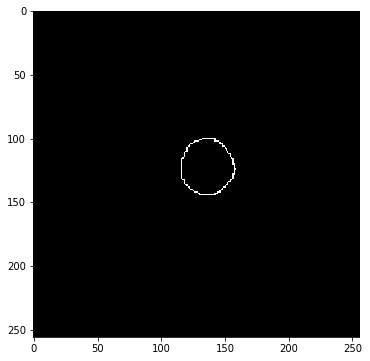

In [41]:
fname = "/home/bob/data/SunnyBrook_clean/contour_nii/SC-N-05_icontour_ES.nii.gz"
icontour_data = sitk.ReadImage(fname)
icontour_labels = sitk.GetArrayFromImage(icontour_data)

fname = "/home/bob/data/SunnyBrook_clean/contour_nii/SC-N-05_ocontour_ES.nii.gz"
ocontour_data = sitk.ReadImage(fname)
ocontour_labels = sitk.GetArrayFromImage(ocontour_data)

print(icontour_labels.shape, ocontour_labels.shape)
print(np.unique(ocontour_labels))

slice_id = 3

plt.rcParams['figure.figsize'] = [8, 6]
plt.imshow(icontour_labels[slice_id], cmap=cm.gray)
plt.show()
plt.imshow(ocontour_labels[slice_id], cmap=cm.gray)
plt.show()

In [34]:
from datasets.data_config import get_config

dta_settings = get_config("ARVC")
image_dir = dta_settings.short_axis_dir
contour_label_dir = dta_settings.ref_label_dir


In [92]:
patient_id = "NLUTR11_7_0"  # frames 10, 11, 30
fname = os.path.join(image_dir, patient_id + ".nii.gz")
img_data = sitk.ReadImage(fname)
print(img_data.GetSize()[::-1])
print(img_data.GetSpacing())

fname = os.path.join(contour_label_dir, patient_id + ".nii.gz")
nifti_ref_labels = sitk.ReadImage(fname)
ref_labels = sitk.GetArrayFromImage(nifti_ref_labels)
print("Label shape ", ref_labels.shape)
num_frames, num_slices, y, x = ref_labels.shape
print(np.unique(ref_labels))

(30, 15, 256, 256)
(1.25, 1.25, 8.000003814697266, 1.0)
Label shape  (30, 15, 256, 256)
[0 1 2]


[0 2]


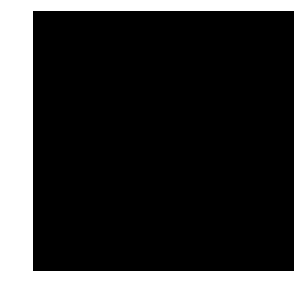

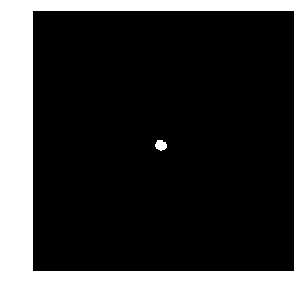

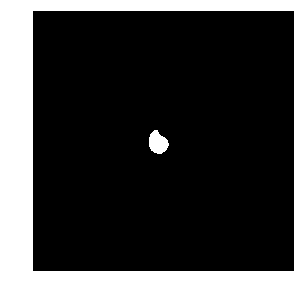

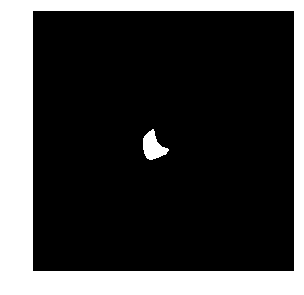

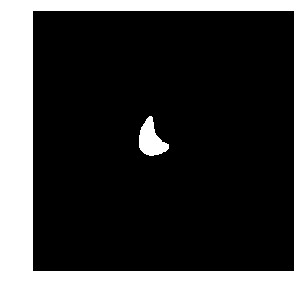

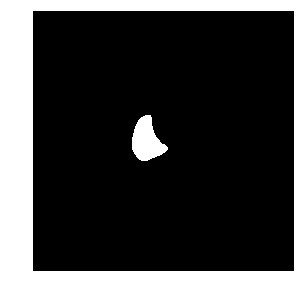

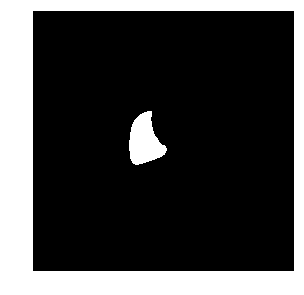

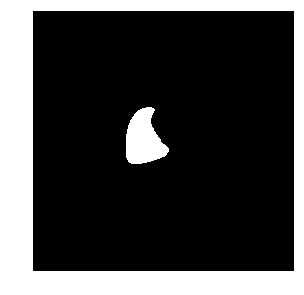

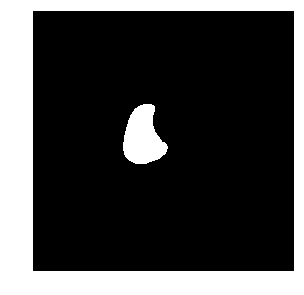

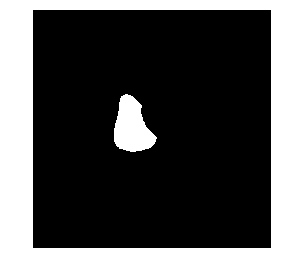

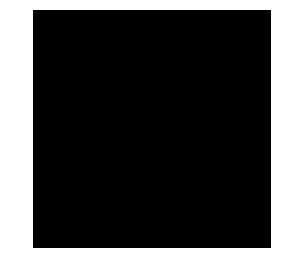

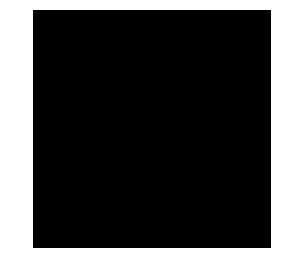

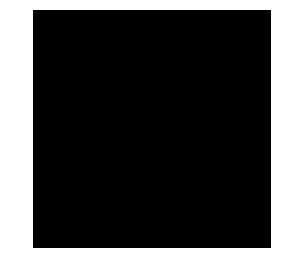

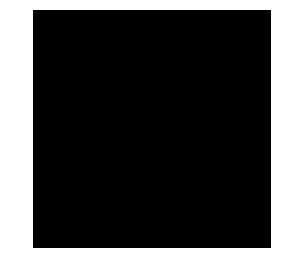

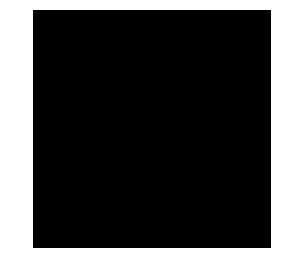

In [93]:
plt.rcParams['figure.figsize'] = [40, 45]
frame_id = 9

ref_label_volume = ref_labels[frame_id]
print(np.unique(ref_label_volume))
# 28: 1=LV 2=RV 

num_rows = ((num_slices / 2) + 1) * 100
plot_id = num_rows + 21
for s in range(num_slices):
    ax = plt.subplot(plot_id + s)
    ax.imshow(ref_label_volume[s] ==2 , cmap=cm.gray)
    plt.axis("off")
    plt.show()